In [2]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import matplotlib.pyplot as plt


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [5]:
import os
from google.colab import files
os.chdir('drive/My Drive/PPT/')
!pwd
!unzip mnist_train.csv.zip

/content/drive/My Drive/PPT
Archive:  mnist_train.csv.zip
  inflating: mnist_train.csv         


In [6]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")
device = get_default_device()
print(device)

def to_device(data,device):
    if isinstance(data, (list,tuple)):
        return [to_device(x,device) for x in data]
    else:
        return data.to(device, non_blocking=True)
    
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

cuda


In [0]:
df_train = pd.read_csv('mnist_train.csv')
target = df_train['label']
df_train.drop('label', axis=1, inplace=True)

In [12]:
X_train, X_dev, y_train, y_dev = train_test_split(df_train, target, stratify=target, random_state=42, test_size=0.020)
print('X_train ', X_train.shape)
print('X_dev ', X_dev.shape)

X_train  (58800, 784)
X_dev  (1200, 784)


In [13]:
import torchvision
print('PIL',torchvision.__version__)

PIL 0.5.0


In [0]:
# import torchvision.transforms.functional as TF
class CharData(Dataset):
    
    def __init__(self,
                 images,
                 labels=None,
                 transform=None,
                ):
        self.X = images
        self.y = labels
        
        self.transform = transform
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        idx2 = int(idx/2)+1#np.random.randint(0, self.__len__(), 1)
        idx3 = int(idx/3)+1
        img1 = np.array(self.X.iloc[idx, :], dtype='uint8').reshape([28, 28, 1])
        img2 = np.array(self.X.iloc[idx2, :], dtype='uint8').reshape([28, 28, 1])
        img3 = np.array(self.X.iloc[idx3, :], dtype='uint8').reshape([28, 28, 1])

        # img1[img1>0] = 255
        # img2[img2>0] = 255
        img3 = 255 - img3

        transform1 = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            # transforms.Normalize([0], [0.5])
        ])
        transform2 = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(degrees=(89,90), fill=(0,)),
            transforms.ToTensor(),
            # transforms.Normalize([0], [0.5])
        ])
#         average = img.sum() / (28*28)
#         img1 = np.ones((28,28,1), dtype='uint8') * int(average)
#         img1 = np.flip(img,1)
#         img = np.concatenate((img, img1), axis=2)

        
        img1 = transform1(img1)
        img2 = transform2(img2)
        img3 = transform1(img3)
        # img1.where(img1>0,1,0)
        # img2.where(img2>0,1,0)
        
        # if self.y is not None:
        #     y = np.zeros(10, dtype='float32')
        #     y[self.y.iloc[idx]] = 1
        #     return img, y
        # else:
        return img1, img2, img3

In [0]:
train_dataset = CharData(X_train, y_train)#, train_transform)
dev_dataset = CharData(X_dev, y_dev)#, transform=test_transform)
# test_dataset = CharData(X_test, transform=test_transform)
batch_size = 100

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
dev_loader = DataLoader(dataset=dev_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
# test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

train_loader = DeviceDataLoader(train_loader, device)
dev_loader = DeviceDataLoader(dev_loader, device)
# test_loader = DeviceDataLoader(test_loader, device)

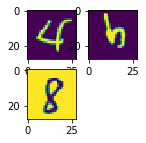

In [18]:
for batch_idx, (x1, x2, x3) in enumerate(train_loader):
    fig=plt.figure(figsize=(2, 2))
    fig.add_subplot(2, 2, 1)
    plt.imshow(x1.cpu().numpy()[2,0,:,:])
    fig.add_subplot(2, 2, 2)
    plt.imshow(x2.cpu().numpy()[2,0,:,:])
    fig.add_subplot(2, 2, 3)
    plt.imshow(x3.cpu().numpy()[2,0,:,:])

    break

In [0]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__() 

        n1,n2,n3,n4 = 64,128,256,512#256,512,1024,1500

        self.fc1 = nn.Linear(g_input_dim, n1)
        self.batchnorm1 = nn.BatchNorm1d(n1)
        self.fc2 = nn.Linear(n1, n2)
        self.batchnorm2 = nn.BatchNorm1d(n2)
        self.fc3 = nn.Linear(n2, n3)
        self.batchnorm3 = nn.BatchNorm1d(n3)
        self.fc4 = nn.Linear(n3, n4)
        self.batchnorm4 = nn.BatchNorm1d(n4)
        self.fc51 = nn.Linear(n4, g_output_dim)
        self.fc52 = nn.Linear(n4, g_output_dim)
        self.fc53 = nn.Linear(n4, g_output_dim)
    
    def forward(self, x): 
        x = F.leaky_relu(self.batchnorm1(self.fc1(x)))
        x = F.leaky_relu(self.batchnorm2(self.fc2(x)))
        x = F.leaky_relu(self.batchnorm3(self.fc3(x)))
        x = F.leaky_relu(self.batchnorm4(self.fc4(x)))
        x1 = torch.sigmoid(self.fc51(x))
        x2 = torch.sigmoid(self.fc52(x))
        x3 = torch.sigmoid(self.fc53(x))
        return x1.view(x1.size(0),1,28,28), x2.view(x2.size(0),1,28,28), x3.view(x3.size(0),1,28,28)
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()

        n1,n2,n3 = 32,64,256#32,64,256

        self.conv11 = nn.Conv2d(1,n1,5)
        self.conv12 = nn.Conv2d(1,n1,5)
        self.conv13 = nn.Conv2d(1,n1,5)

        self.conv21 = nn.Conv2d(n1,n2,5)
        self.conv22 = nn.Conv2d(n1,n2,5)
        self.conv23 = nn.Conv2d(n1,n2,5)

        # self.fc11 = nn.Linear(16*n2,n3)
        # self.fc12 = nn.Linear(16*n2,n3)
        # self.fc13 = nn.Linear(16*n2,n3)

        self.fc1 = nn.Linear(16*n2,n3)

        # self.fc21 = nn.Linear(n3,1)
        # self.fc22 = nn.Linear(n3,1)
        # self.fc23 = nn.Linear(n3,1)
        #
        self.fc2 = nn.Linear(n3,1)

    def forward(self, x1, x2, x3):
        x1 = F.max_pool2d(self.conv11(x1), 2)
        x2 = F.max_pool2d(self.conv12(x2), 2)
        x3 = F.max_pool2d(self.conv13(x3), 2)

        x1 = F.max_pool2d(self.conv21(x1), 2)
        x2 = F.max_pool2d(self.conv22(x2), 2)  
        x3 = F.max_pool2d(self.conv23(x3), 2) 

        x1 = x1.view(-1, self.num_flat_features(x1))
        x2 = x2.view(-1, self.num_flat_features(x2))
        x3 = x3.view(-1, self.num_flat_features(x3))

        # x1 = F.leaky_relu(self.fc11(x1))
        # x2 = F.leaky_relu(self.fc12(x2))
        # x3 = F.leaky_relu(self.fc13(x3))

        # x1 = torch.sigmoid(self.fc21(x1))
        # x2 = torch.sigmoid(self.fc22(x2))
        # x3 = torch.sigmoid(self.fc23(x3))

        # return x1,x2,x3

        x = x1+x2+x3
        x = F.leaky_relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))

        return x#x1, x2, x3
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [0]:
def D_train(x1, x2, x3):
    D.zero_grad()
    G.zero_grad()

    # train discriminator on real
    x_real1 = x1#.view(-1, mnist_dim)
    y_real1 = torch.ones(bs, 1)
    x_real1, y_real1 = x_real1.to(device), y_real1.to(device)

    x_real2 = x2 #x2.view(-1, mnist_dim), 
    y_real2 = torch.ones(bs, 1)
    x_real2, y_real2 = x_real2.to(device), y_real2.to(device)

    x_real3 = x3#.view(-1, mnist_dim)
    y_real3 = torch.ones(bs, 1)
    x_real3, y_real3 = x_real3.to(device), y_real3.to(device)

    # D_output1, D_output2, D_output3 = D(x_real1,x_real2,x_real3)
    D_output = D(x_real1,x_real2,x_real3)
    # D_real_loss1 = (criterion(D_output1, y_real1) + criterion(D_output2, y_real2) + criterion(D_output3, y_real3))/3
    D_real_loss1 = criterion(D_output, y_real1)
    # train discriminator on fake
    z = torch.randn(bs, z_dim).to(device)

    x_fake1, x_fake2, x_fake3  = G(z)
    y_fake1 = torch.zeros(bs, 1).to(device)
    y_fake2 = torch.zeros(bs, 1).to(device)
    y_fake3 = torch.zeros(bs, 1).to(device)

    # D_output1, D_output2, D_output3 = D(x_fake1, x_fake2, x_fake3)
    D_output = D(x_fake1, x_fake2, x_fake3)
    # D_fake_loss1 = (criterion(D_output1, y_fake1) + criterion(D_output2, y_fake2) + criterion(D_output3, y_fake3))/3
    D_fake_loss1 = criterion(D_output, y_fake1)

    # gradient backprop & optimize ONLY D's parameters
    D_loss = (D_real_loss1 + D_fake_loss1)/2 # + D_fake_loss2
    D_loss.backward()
    D_optimizer.step()

    return  D_loss#.data.item()


def G_train():
    G.zero_grad()
    D.zero_grad()

    z = torch.randn(bs, z_dim).to(device)
    y = torch.ones(bs, 1).to(device)

    G_output1, G_output2, G_output3 = G(z)
    # D_output1, D_output2, D_output3 = D(G_output1,G_output2,G_output3)
    D_output = D(G_output1,G_output2,G_output3)

    # G_loss = (criterion(D_output1, y) + criterion(D_output2, y) + criterion(D_output3, y))/3
    G_loss = criterion(D_output,y)
    G_loss.backward()
    G_optimizer.step()
    return G_loss.data.item()

In [0]:
# !rm -rf results
# !rm -rf saved_model
# !mkdir results
# !mkdir saved_model

# !mv new_models/D_20.pth saved_model/D_20.pth
# !mv new_models/G_20.pth saved_model/G_20.pth

In [67]:
# build network
z_dim = 50
bs = batch_size

mnist_dim = train_dataset.X.shape[1]# * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

# G.load_state_dict(torch.load('new_models/G_170.pth'))
# D.load_state_dict(torch.load('new_models/D_170.pth'))

criterion = nn.BCELoss()

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)

G.apply(weights_init)
D.apply(weights_init)

Discriminator(
  (conv11): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv12): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv13): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv21): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv22): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv23): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)

In [0]:
G_optimizer = optim.Adam(G.parameters(), lr = 0.0005, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr = 0.0005, betas=(0.5, 0.999))

In [69]:
# !mkdir new_models1
# !mkdir results1
!ls

mnist_train.csv      new_models   results
mnist_train.csv.zip  new_models1  results1


In [0]:
n_epoch = 300
torch.manual_seed(7)
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x1, x2, x3) in enumerate(train_loader):
        D_losses.append(D_train(x1,x2,x3))
        G_losses.append(G_train())

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
    if epoch%2==0:
        with torch.no_grad():
            test_z = torch.randn(bs, z_dim).to(device)
            g1, g2, g3 = G(test_z)
            save_image(g1.view(g1.size(0), 1, 28, 28), 'results1/sample_%03d_1.png'%epoch)
            save_image(g2.view(g2.size(0), 1, 28, 28), 'results1/sample_%03d_2.png'%epoch)
            save_image(g3.view(g3.size(0), 1, 28, 28), 'results1/sample_%03d_3.png'%epoch)
            torch.save(G.state_dict(), "new_models1/G_%03d.pth"%epoch)
            torch.save(D.state_dict(), "new_models1/D_%03d.pth"%epoch)


In [0]:
with torch.no_grad():
    test_z = Variable(torch.randn(bs, z_dim).to(device))
    generated = G(test_z)

    save_image(generated.view(generated.size(0), 1, 28, 28), 'sample_{}.png'.format(epoch))

In [145]:
# !mkdir new_models
i = 1
print('results/sample_%02d_1.png'%i)

results/sample_01_1.png


In [0]:
torch.save(D.state_dict(), "new_models/D_55.pth")
torch.save(G.state_dict(), "new_models/G_55.pth")

In [0]:
%matplotlib inline
def show(img):
    npimg = img.detach().cpu().numpy()[0]
    plt.imshow(npimg, interpolation='nearest')

In [0]:
from torchvision.transforms import ToPILImage
# from IPython.display import Image
to_img = ToPILImage()

# display tensor
# a = t.Tensor(3, 64, 64).normal_()
# to_img(a)
# torch.manual_seed(10)
test_z = Variable(torch.randn(bs, z_dim).to(device))
generated, generated_rotate = G(test_z)
# generated.view(generated.size(0), 1, 28, 28)
# to_img(generated.view(generated.size(0), 1, 28, 28)[1].cpu())
show(generated.view(generated.size(0), 1, 28, 28)[3])


In [0]:
# def G_train(x,x_rotate):
#     #=======================Train the generator 1=======================#
#     G.zero_grad()

#     z = Variable(torch.randn(bs, z_dim).to(device))
#     y = Variable(torch.ones(bs, 1).to(device))

#     G_output1 = G(z)
#     D_output1 = D(G_output1)
#     G_loss1 = criterion(D_output1, y)

#     # gradient backprop & optimize ONLY G's parameters
#     G_loss1.backward()
#     G_optimizer.step()
    
#     #=======================Train the generator 2=======================#
    
#     G_rotate.zero_grad()

#     # z = Variable(torch.randn(bs, z_dim).to(device))
#     # y = Variable(torch.ones(bs, 1).to(device))

#     G_output2 = G_rotate(z)
#     D_output2 = D_rotate(G_output2)
#     G_loss2 = criterion(D_output2, y)

#     # gradient backprop & optimize ONLY G's parameters
#     G_loss2.backward()
#     G_rotate_optimizer.step()


#     return G_loss1.data.item() + G_loss2.data.item()



# def D_train(x1, x2):
#     #=======================Train the discriminator 1=======================#
#     D.zero_grad()

#     # train discriminator on real
#     x_real1, y_real1 = x1.view(-1, mnist_dim), torch.ones(bs, 1)
#     x_real1, y_real1 = Variable(x_real1.to(device)), Variable(y_real1.to(device))

#     D_output1 = D(x_real1)
#     D_real_loss1 = criterion(D_output1, y_real1)
#     D_real_score1 = D_output1

#     # train discriminator on facke
#     z = Variable(torch.randn(bs, z_dim).to(device))
#     x_fake1, y_fake1 = G(z), Variable(torch.zeros(bs, 1).to(device))

#     D_output1 = D(x_fake1)
#     D_fake_loss1 = criterion(D_output1, y_fake1)
#     D_fake_score1 = D_output1

#     # gradient backprop & optimize ONLY D's parameters
#     D_loss1 = D_real_loss1 + D_fake_loss1
#     D_loss1.backward()
#     D_optimizer.step()

#     #=======================Train the discriminator 2=======================# 
#     D_rotate.zero_grad()

#     x_real2, y_real2 = x2.view(-1, mnist_dim), torch.ones(bs, 1)
#     x_real2, y_real2 = Variable(x_real2.to(device)), Variable(y_real2.to(device))

#     D_output2 = D_rotate(x_real2)
#     D_real_loss2 = criterion(D_output2, y_real2)
#     D_real_score2 = D_output2

#     # train discriminator on facke
#     # z = Variable(torch.randn(bs, z_dim).to(device))
#     x_fake2, y_fake2 = G_rotate(z), Variable(torch.zeros(bs, 1).to(device))

#     D_output2 = D_rotate(x_fake2)
#     D_fake_loss2 = criterion(D_output2, y_fake2)
#     D_fake_score2 = D_output2

#     # gradient backprop & optimize ONLY D's parameters
#     D_loss2 = D_real_loss2 + D_fake_loss2
#     D_loss2.backward()
#     D_rotate_optimizer.step()
        
#     return  D_loss1.data.item()# + D_loss2.data.item()


In [0]:
# bs = 100

# # MNIST Dataset
# transform = transforms.Compose([
#     transforms.ToTensor()])#,
#     # transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
# transform_rotate = transforms.Compose([
#     transforms.ToTensor(),
#     ])#,
#     # transforms.RandomRotation((90,90))])


# train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
# test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# train_dataset_rotate = datasets.MNIST(root='./mnist_data/', train=True, transform=transform_rotate, download=True)
# test_dataset_rotate = datasets.MNIST(root='./mnist_data/', train=False, transform=transform_rotate, download=False)

# # Data Loader (Input Pipeline)
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

# train_loader_rotate = torch.utils.data.DataLoader(dataset=train_dataset_rotate, batch_size=bs, shuffle=True)
# test_loader_rotate = torch.utils.data.DataLoader(dataset=test_dataset_rotate, batch_size=bs, shuffle=False)